<a href="https://colab.research.google.com/github/amazon4b/Learning-Machine/blob/learner1/%EA%B2%BD%EA%B8%B0%EB%B6%84%EC%84%9D%2Ck_means(k%3D4)%2Cmeanshift%2C_minmax%EC%8A%A4%EC%BC%80%EC%9D%BC%EB%A7%81_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings

# 경고 메시지를 출력하지 않도록 설정
warnings.filterwarnings("ignore")

# 경고 메시지를 발생시키는 함수
def example_function():
    warnings.warn("이 함수는 예제일 뿐입니다.", UserWarning)

# 함수 호출
example_function()

In [2]:
# 기본패키지 설치
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans # 케이민즈 알고리즘
from sklearn.preprocessing import StandardScaler# 스텐다드 스케일러
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc

In [3]:
# 데이터프레임 불러오기
economics = pd.read_csv('./datasets/resampled_data_final.csv',encoding="euc-kr")
economics['DATE'] = pd.to_datetime(economics['DATE'])
economics['DATE'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 289 entries, 0 to 288
Series name: DATE
Non-Null Count  Dtype         
--------------  -----         
287 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.4 KB


In [4]:
economics.drop(['장단기10년물국채/3개월금리차','신규실업수당청구','금융상태지수레버리지','제조업신규주문'],axis=1,inplace=True)

In [5]:
economics[economics.isna().any(axis=1)] # 결측치 확인

,DATE,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,소비자감성지수,기준금리,M2통화량,경기동행종합,산업생산지수,소매판매
287,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
288,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
economics = economics.iloc[:287 , ] # 결측치 제거
economics[economics.isna().any(axis=1)] # 결측치 확인

,DATE,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,소비자감성지수,기준금리,M2통화량,경기동행종합,산업생산지수,소매판매


In [7]:
# 2000년~2019년만 군집화하기 위함 , 코로나 데이터가 이상치로 잡히기 때문에 군집이 제대로 형성되지 않음
economics = economics.loc[economics['DATE'].dt.year <=2019 ]

In [8]:
economics.tail()

,DATE,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,소비자감성지수,기준금리,M2통화량,경기동행종합,산업생산지수,소매판매
235,2019-08-31,0.00,54.806,3.6,1367.0,211.703,-0.538,89.8,2.13,14914.6,127.81,102.7754,521011.0
236,2019-09-30,0.05,56.947,3.5,1300.0,211.881,-0.505,93.2,2.04,15008.1,128.20,102.5315,518121.0
237,2019-10-31,0.17,53.963,3.6,1332.0,211.974,-0.510,95.5,1.83,15140.8,128.41,101.6022,519530.0
238,2019-11-30,0.17,57.049,3.6,1346.0,212.112,-0.557,96.8,1.55,15242.2,128.67,102.1480,523313.0
239,2019-12-31,0.34,59.817,3.6,1551.0,212.243,-0.539,99.3,1.55,15320.7,128.91,101.8840,525405.0


In [9]:
# 주택가격지수. 제조업신규주문 , 경기동행종합지수는 차분하고 (변동치로 변경한다는 뜻)
# 제조업 신규주문은 앞으로 어떻게 처리할지 일단 보류
#M2와 소매판매는 변화율로 바꾸는 전처리 시행
economics.주택가격지수 = economics.주택가격지수.diff().fillna(method= 'bfill')
economics.경기동행종합 = economics.경기동행종합.diff().fillna(method= 'bfill')
economics['M2차분'] = economics.M2통화량.diff().fillna(method= 'bfill')
economics['M2변화율'] = economics.M2차분/ (economics.M2통화량.shift(1)) * 100
#economics['M2변화율'] .fillna(method = 'ffill')
economics['소매판매차분'] = economics.소매판매.diff().fillna(method='bfill')
economics['소매판매변화율'] = economics.소매판매차분/ (economics.소매판매.shift(1)) * 100


# 차분, 변화율 확인
economics[['M2통화량','M2차분','M2변화율','소매판매','소매판매차분','소매판매변화율']].head(10)
# 결측치를 다음날 데이터로 채워주기
economics['M2변화율'] = economics['M2변화율'].fillna(method = 'bfill')
economics['소매판매변화율'] = economics['소매판매변화율'].fillna(method = 'bfill')
# M2, 소매판매 원데이터를 지웠습니다.
economics.drop(['M2통화량','M2차분','소매판매','소매판매차분'],axis = 1,inplace = True)

In [10]:
# 다시 날짜를 인덱스로 설정해주기
economics = economics.set_index('DATE')

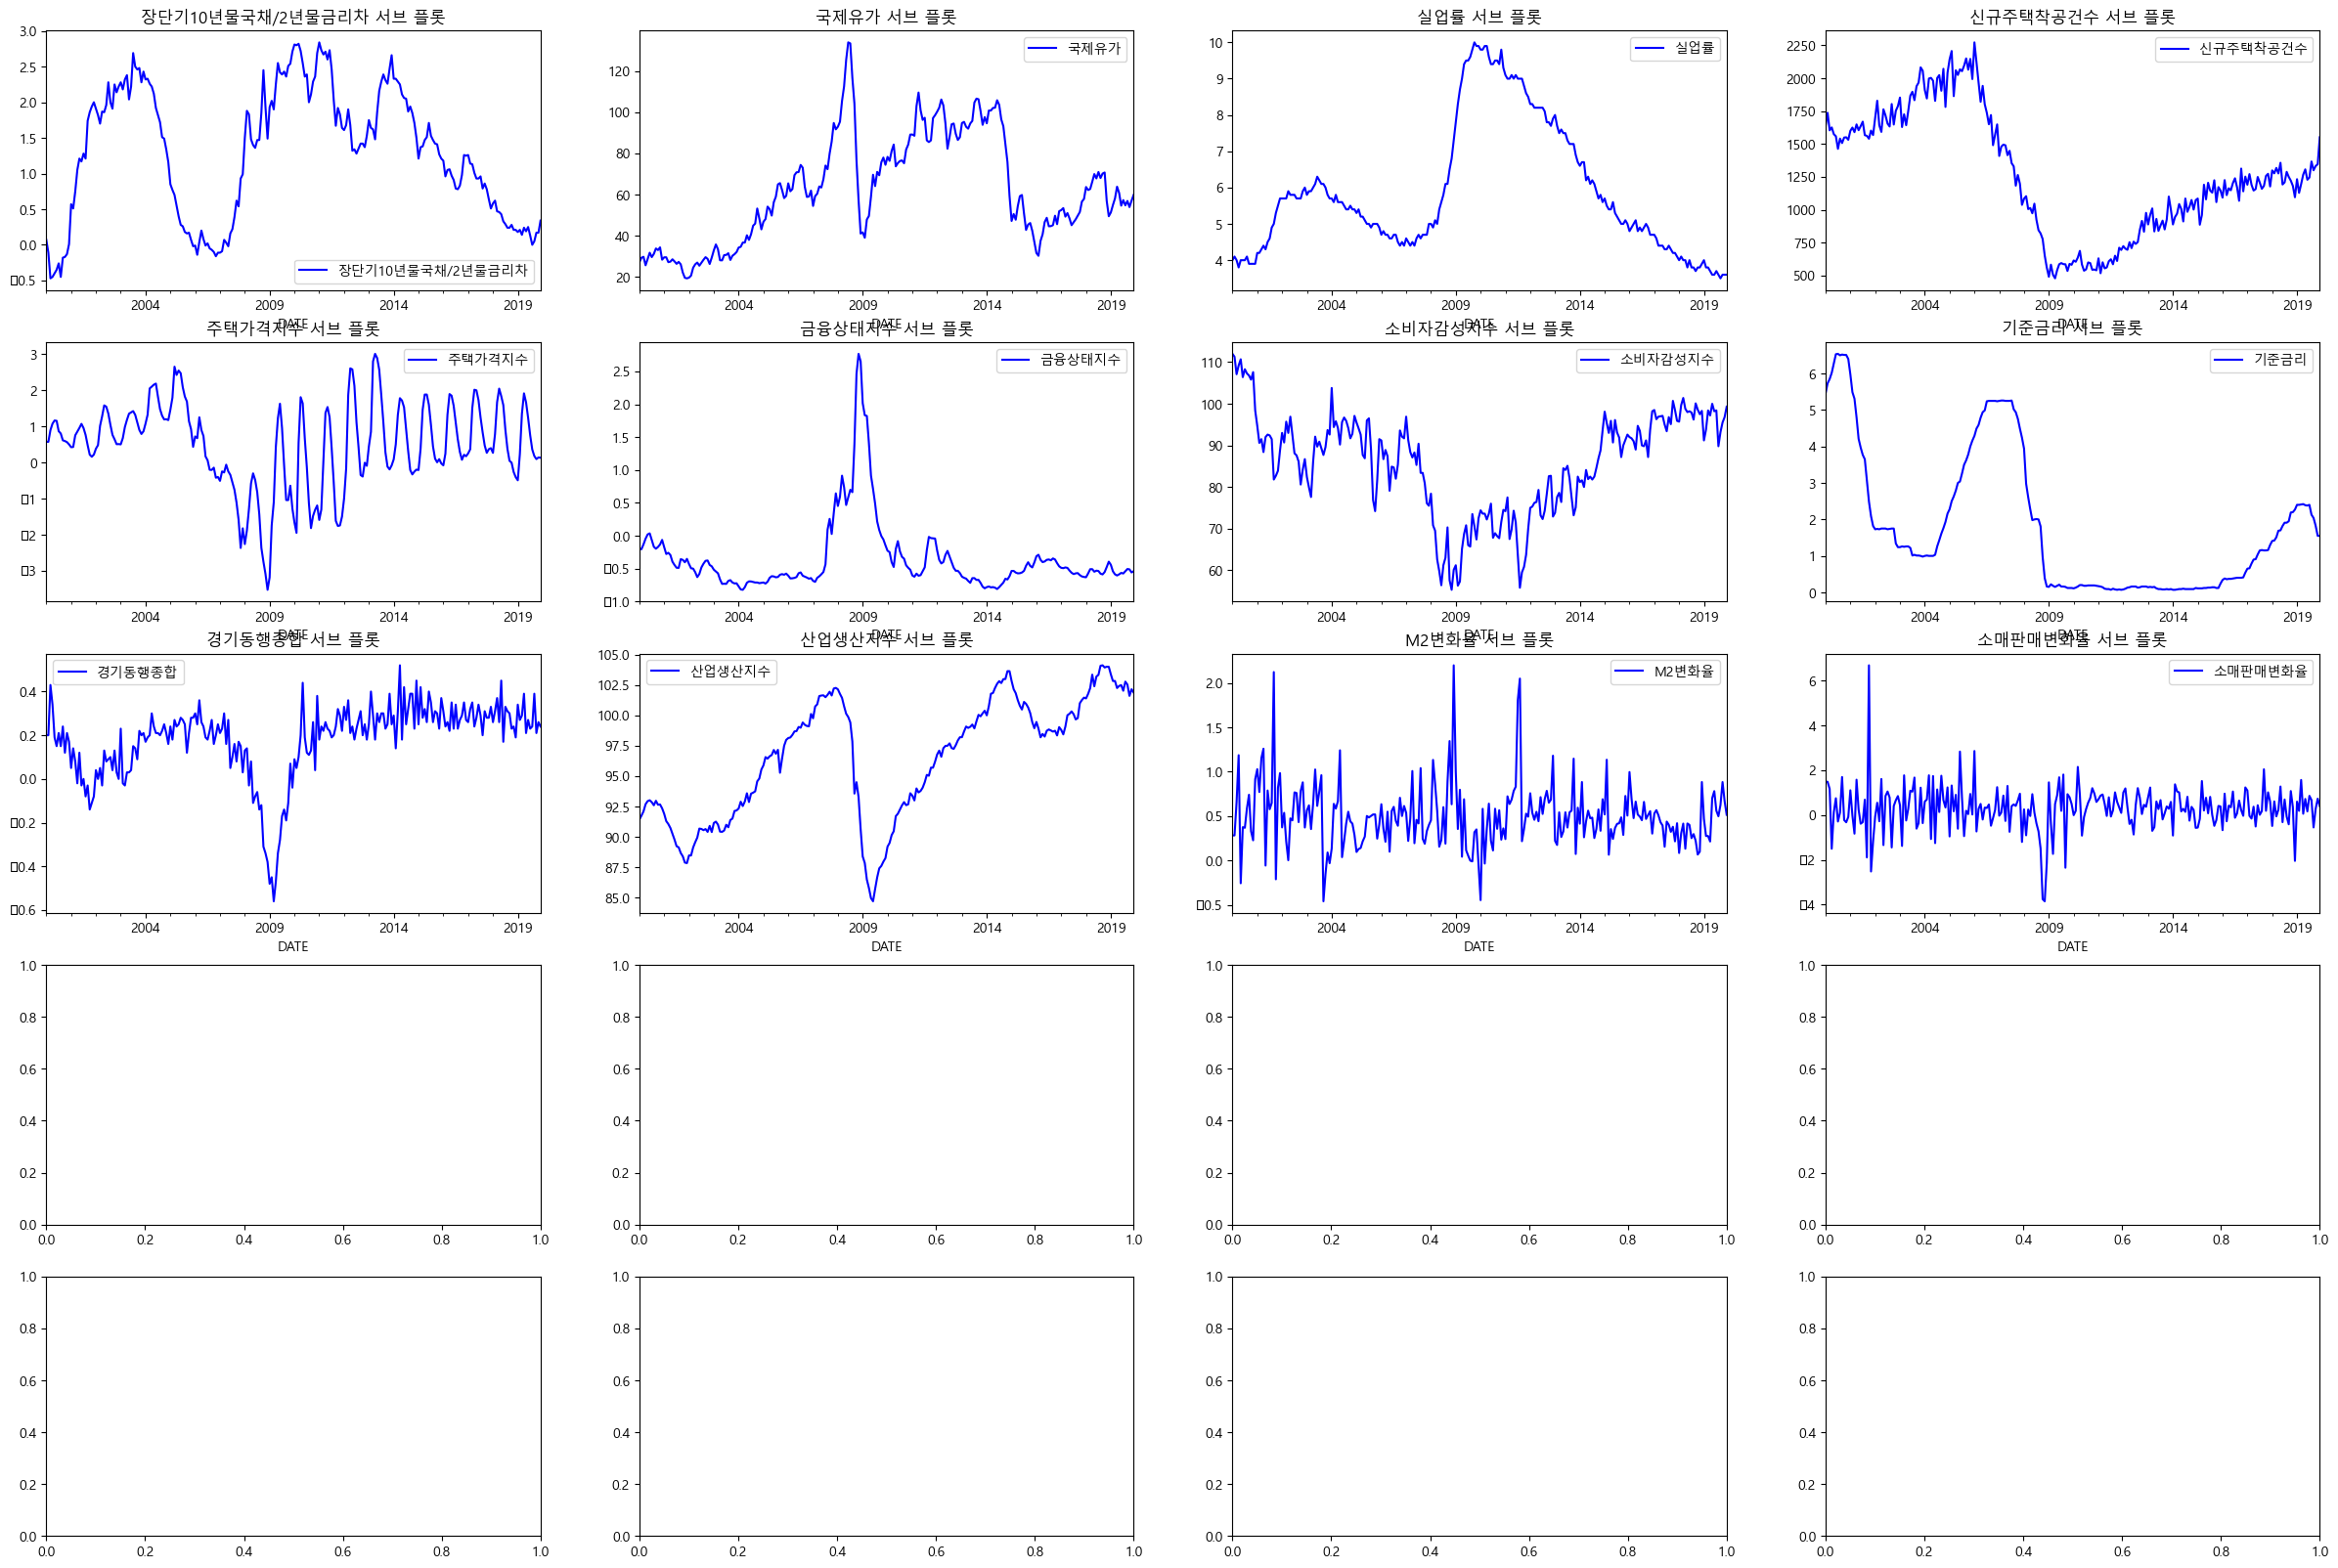

In [11]:
# 그래프 크기 조정
plt.rcParams['font.family'] ='Malgun Gothic'
가로, 세로 = 30, 20  # 원하는 크기로 조절
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(가로, 세로))  # 3행 4열의 서브 플롯 생성
# 각 컬럼에 대한 서브 플롯 그리기
for i, col in enumerate(economics.columns):
    economics.plot(y= col, kind='line', ax=axs[i//4, i%4], color='blue')
    axs[i//4, i%4].set_title(f'{col} 서브 플롯')

# 그래프 출력
plt.show()

#### 스케일링

In [12]:
# scikit-learn 패키지의 StandardScaler 클래스를 불러옵니다.
from sklearn.preprocessing import StandardScaler
# StandardScaler 객체를 생성합니다.
standard_scaler = StandardScaler()
# fit_transform()을 사용해서 학습과 스케일링을 한 번에 적용합니다.
scaled_df = standard_scaler.fit_transform(economics)
# 표준화가 완료된 데이터를 데이터프레임 형태로 변환합니다.
scaled_df = pd.DataFrame(scaled_df,
                              index=economics.index,
                              columns=economics.columns)
# 표준화가 잘 되었는지 데이터를 확인해봅시다.
scaled_df.head()

,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,소비자감성지수,기준금리,경기동행종합,산업생산지수,M2변화율,소매판매변화율
DATE,,,,,,,,,,,,
2000-01-31,-1.358922,-1.322363,-1.041818,0.794549,0.084752,0.270843,2.143427,1.916132,0.123418,-1.022683,-0.603253,1.181786
2000-02-29,-1.556543,-1.241600,-0.986439,1.011004,0.084752,0.251169,2.086199,2.062488,0.123418,-0.959506,-0.603253,1.181786
2000-03-31,-1.951786,-1.223355,-1.041818,0.725970,0.356788,0.383517,1.742831,2.125212,1.456621,-0.886769,0.447297,0.867074
2000-04-30,-1.929828,-1.381277,-1.152576,0.773118,0.507079,0.537326,1.914515,2.214071,0.934933,-0.766660,1.926844,-1.784234
2000-05-31,-1.874933,-1.263755,-1.041818,0.663820,0.580965,0.653577,2.037146,2.344746,0.065453,-0.715037,-2.111568,-0.162329


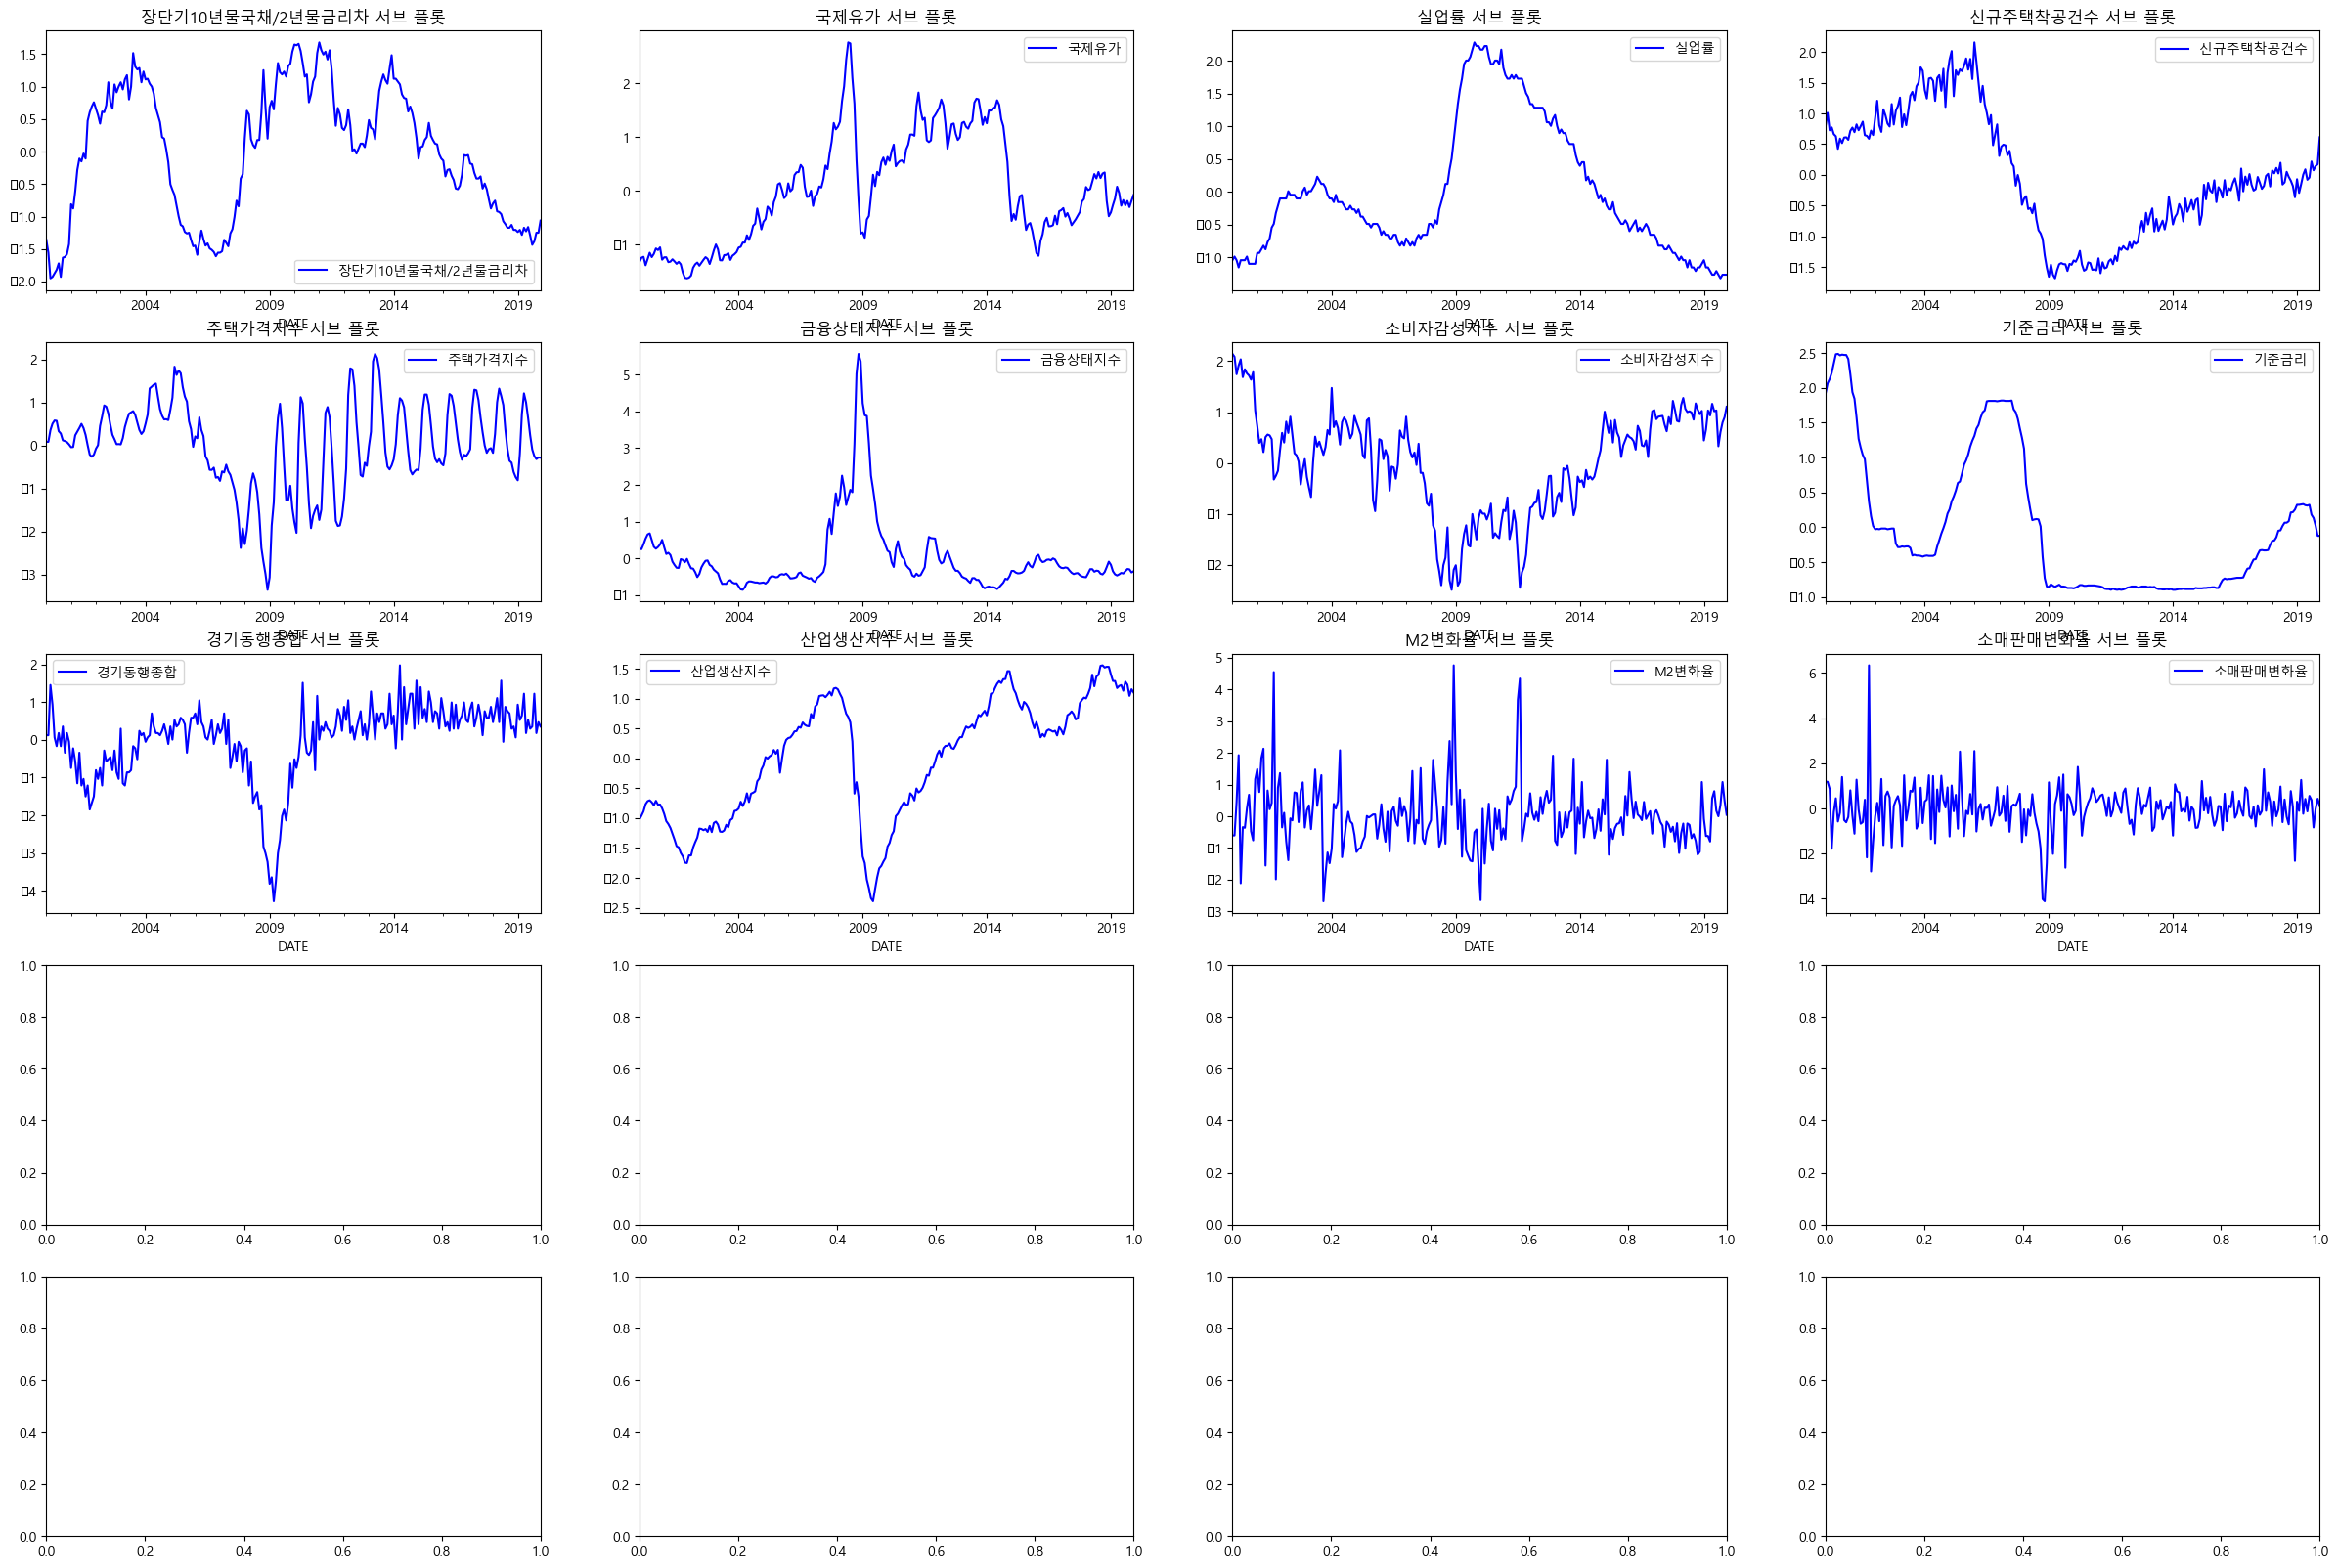

In [13]:
# 스케일링한 데이터를 간단하게 시각화 해서 보기
가로, 세로 = 30, 20  # 원하는 크기로 조절
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(가로, 세로))  # 3행 4열의 서브 플롯 생성
# 각 컬럼에 대한 서브 플롯 그리기
for i, col in enumerate(scaled_df.columns):
    scaled_df.plot(y= col, kind='line', ax=axs[i//4, i%4], color='blue')
    axs[i//4, i%4].set_title(f'{col} 서브 플롯')

# 그래프 출력
plt.show()

#### GaussianMixture

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D



In [21]:
from sklearn.mixture import GaussianMixture
from numpy import unique
from numpy import where

# define the model : n_components=3 (cluster 갯수)
gmm = GaussianMixture(n_components=5)

# train the model
gmm_label = gmm.fit(scaled_df).predict(scaled_df)

# assign each data point to a cluster
scaled_df['gmm_cluster'] = gmm_label

# get all of the unique clusters
gaussian_clusters = unique(scaled_df['gmm_cluster'])
print(gaussian_clusters)

scaled_df['gmm_cluster'].value_counts()

[0 1 2 3 4]


gmm_cluster
3    77
4    76
1    46
0    26
2    15
Name: count, dtype: int64

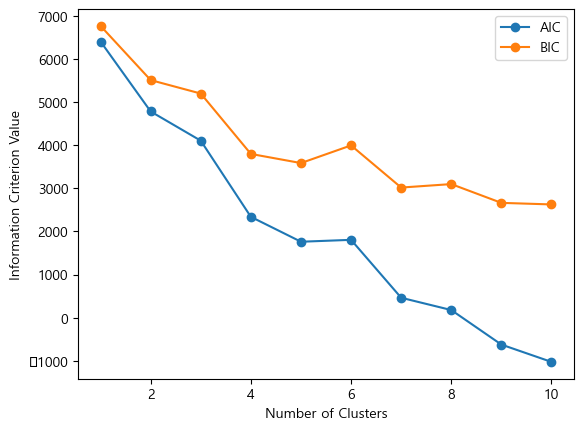

In [19]:
# 최대 클러스터 개수 설정
max_clusters = 10

# AIC와 BIC 값을 저장할 리스트 초기화
aic_values = []
bic_values = []

# 클러스터 개수를 변화시키면서 GMM 학습
for n_clusters in range(1, max_clusters + 1):
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(scaled_df)
    
    # AIC와 BIC 계산 및 리스트에 추가
    aic_values.append(gmm.aic(scaled_df))
    bic_values.append(gmm.bic(scaled_df))

# AIC와 BIC 값의 그래프를 그려서 최적 클러스터 개수 확인
import matplotlib.pyplot as plt

plt.plot(range(1, max_clusters + 1), aic_values, marker='o', label='AIC')
plt.plot(range(1, max_clusters + 1), bic_values, marker='o', label='BIC')
plt.xlabel('Number of Clusters')
plt.ylabel('Information Criterion Value')
plt.legend()
plt.show()


In [22]:
scaled_df.head()

,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,소비자감성지수,기준금리,경기동행종합,산업생산지수,M2변화율,소매판매변화율,gmm_cluster
DATE,,,,,,,,,,,,,
2000-01-31,-1.36,-1.32,-1.04,0.79,0.08,0.27,2.14,1.92,0.12,-1.02,-0.60,1.18,2
2000-02-29,-1.56,-1.24,-0.99,1.01,0.08,0.25,2.09,2.06,0.12,-0.96,-0.60,1.18,2
2000-03-31,-1.95,-1.22,-1.04,0.73,0.36,0.38,1.74,2.13,1.46,-0.89,0.45,0.87,2
2000-04-30,-1.93,-1.38,-1.15,0.77,0.51,0.54,1.91,2.21,0.93,-0.77,1.93,-1.78,2
2000-05-31,-1.87,-1.26,-1.04,0.66,0.58,0.65,2.04,2.34,0.07,-0.72,-2.11,-0.16,2


In [23]:
scaled_df['gmm_cluster'].unique()

array([2, 1, 4, 0, 3], dtype=int64)

In [24]:
# 각 군집마다 해당되는 월의 개수를 표시해줍니다.
data_list = list(scaled_df['gmm_cluster'].value_counts())
for i, j  in enumerate(data_list) :
    print(f'{i}번째 클러스터 개수는 {j}개 입니다')

0번째 클러스터 개수는 77개 입니다
1번째 클러스터 개수는 76개 입니다
2번째 클러스터 개수는 46개 입니다
3번째 클러스터 개수는 26개 입니다
4번째 클러스터 개수는 15개 입니다


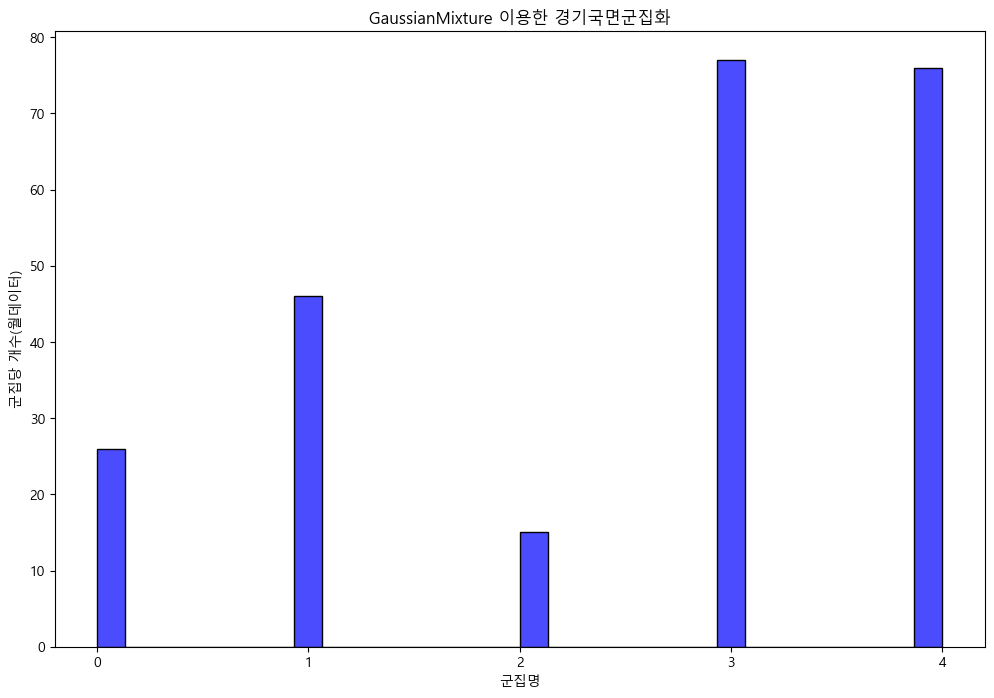

In [25]:
# k-means 군집화의 클러스터를 시각화
import matplotlib.ticker as ticker
# Seaborn 히스토그램 그리기
b=  scaled_df['gmm_cluster'].astype(int)


# Seaborn 히스토그램 그리기
plt.figure(figsize=(12, 8))
ax = sns.histplot(b, bins=30, kde=False, color='blue', alpha=0.7)

# x축 눈금을 정수로 바꾸는 함수
def format_func(value, tick_number):
    return int(value)

# x축 눈금에 함수 적용
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_func))

# 그래프 제목과 축 레이블 추가
plt.title('GaussianMixture 이용한 경기국면군집화')
plt.xlabel('군집명')
plt.ylabel('군집당 개수(월데이터)')

# 그래프 보이기
plt.show()

#### ANOVA

In [27]:
scaled_df['gmm_cluster'].unique()

array([2, 1, 4, 0, 3], dtype=int64)

In [28]:
cluster0 = scaled_df[scaled_df['gmm_cluster']==0]
cluster1 = scaled_df[scaled_df['gmm_cluster']==1]
cluster2 = scaled_df[scaled_df['gmm_cluster']==2]
cluster3 = scaled_df[scaled_df['gmm_cluster']==3]
cluster4 = scaled_df[scaled_df['gmm_cluster']==4]

In [30]:
scale = scaled_df.copy()

In [31]:
scale = scale.reset_index()
scale.head()

,DATE,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,소비자감성지수,기준금리,경기동행종합,산업생산지수,M2변화율,소매판매변화율,gmm_cluster
0,2000-01-31,-1.36,-1.32,-1.04,0.79,0.08,0.27,2.14,1.92,0.12,-1.02,-0.60,1.18,2
1,2000-02-29,-1.56,-1.24,-0.99,1.01,0.08,0.25,2.09,2.06,0.12,-0.96,-0.60,1.18,2
2,2000-03-31,-1.95,-1.22,-1.04,0.73,0.36,0.38,1.74,2.13,1.46,-0.89,0.45,0.87,2
3,2000-04-30,-1.93,-1.38,-1.15,0.77,0.51,0.54,1.91,2.21,0.93,-0.77,1.93,-1.78,2
4,2000-05-31,-1.87,-1.26,-1.04,0.66,0.58,0.65,2.04,2.34,0.07,-0.72,-2.11,-0.16,2


In [32]:
scale.columns

Index(['DATE', '장단기10년물국채/2년물금리차', '국제유가', '실업률', '신규주택착공건수', '주택가격지수',
       '금융상태지수', '소비자감성지수', '기준금리', '경기동행종합', '산업생산지수', 'M2변화율', '소매판매변화율',
       'gmm_cluster'],
      dtype='object')

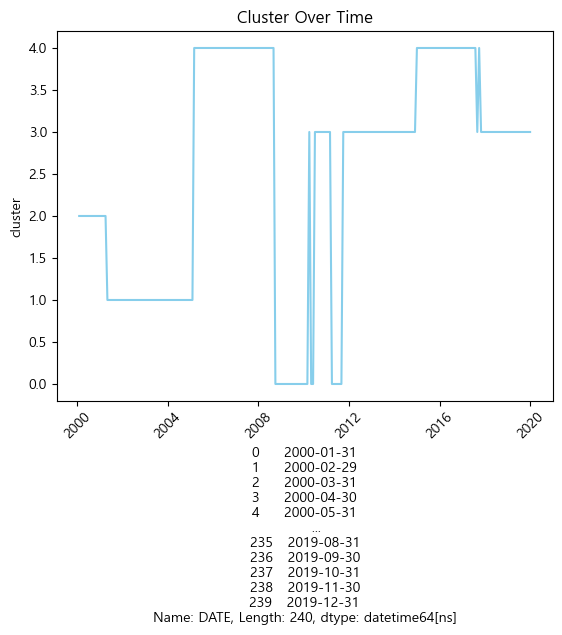

In [33]:
# 그래프 그리기
plt.plot(scale['DATE'], scale['gmm_cluster'], color='skyblue')

# 그래프 세부 설정
plt.xlabel(scale['DATE'])
plt.ylabel('cluster')
plt.title('Cluster Over Time')
plt.xticks(rotation=45)

# 그래프 표시
plt.show()


In [ ]:
# 2008년 전 후로 다른 점이 확인됨

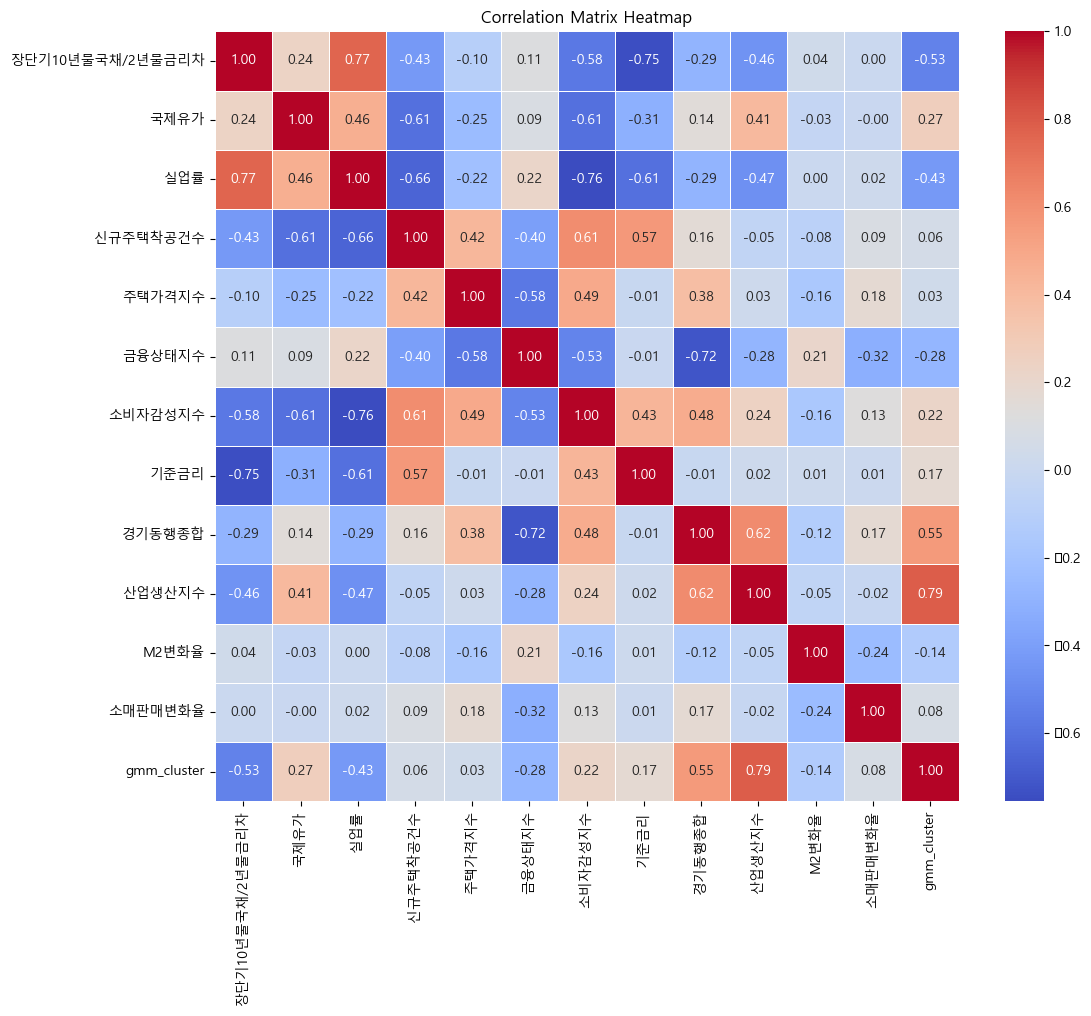

In [34]:
# 독립성 검정
import matplotlib.pyplot as plt
import seaborn as sns

# 상관 행렬 계산
correlation_matrix = scaled_df[scaled_df.columns].corr()

# 히트맵 그리기
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [38]:
# 정규성 검정 (Shapiro-Wilk)
# 귀무가설 : 정규분포를 따른다
from scipy.stats import shapiro

# 클러스터별 feature에 대해 정규성 검정 수행
for cluster_num in range(5):  # 클러스터 번호는 0부터 3까지 총 4개
    cluster_data = scaled_df[scaled_df['gmm_cluster'] == cluster_num]
    
    print(f"\nCluster {cluster_num} - Shapiro-Wilk Test:")
    for column in cluster_data.columns:
        shapiro_test = shapiro(cluster_data[column])
        if shapiro_test.pvalue >= 0.05:
            print(f"{column} - p-value: {shapiro_test.pvalue}")


Cluster 0 - Shapiro-Wilk Test:
국제유가 - p-value: 0.35792893171310425
주택가격지수 - p-value: 0.12502095103263855
경기동행종합 - p-value: 0.20695379376411438
gmm_cluster - p-value: 1.0

Cluster 1 - Shapiro-Wilk Test:
주택가격지수 - p-value: 0.3068534731864929
소비자감성지수 - p-value: 0.2545201778411865
경기동행종합 - p-value: 0.06980457901954651
산업생산지수 - p-value: 0.15366587042808533
M2변화율 - p-value: 0.05328408256173134
gmm_cluster - p-value: 1.0

Cluster 2 - Shapiro-Wilk Test:
국제유가 - p-value: 0.6655761003494263
실업률 - p-value: 0.2958081066608429
신규주택착공건수 - p-value: 0.6783682703971863
주택가격지수 - p-value: 0.10045154392719269
금융상태지수 - p-value: 0.47989875078201294
경기동행종합 - p-value: 0.12693318724632263
산업생산지수 - p-value: 0.08018041402101517
M2변화율 - p-value: 0.607501208782196
소매판매변화율 - p-value: 0.4537713825702667
gmm_cluster - p-value: 1.0

Cluster 3 - Shapiro-Wilk Test:
주택가격지수 - p-value: 0.10087373107671738
경기동행종합 - p-value: 0.5791867971420288
M2변화율 - p-value: 0.08916716277599335
gmm_cluster - p-value: 1.0

Cluster 4 - Shapir

In [36]:
scaled_df2 = scaled_df[['실업률' ,'주택가격지수' ,'산업생산지수','소매판매변화율','국제유가' ,'신규주택착공건수','경기동행종합','M2변화율','소비자감성지수','금융상태지수','gmm_cluster']]

In [39]:
cluster0 = scaled_df2[scaled_df2['gmm_cluster']==0]
cluster1 = scaled_df2[scaled_df2['gmm_cluster']==1]
cluster2 = scaled_df2[scaled_df2['gmm_cluster']==2]
cluster3 = scaled_df2[scaled_df2['gmm_cluster']==3]
cluster4 = scaled_df2[scaled_df2['gmm_cluster']==4]

In [40]:
# 등분산성 검정 - 바틀렛검정
# 귀무가설 : 등분산성의 특징이 있다
from scipy.stats import bartlett

# 등분산성 검정을 수행할 데이터프레임들
dataframes = [cluster0, cluster1, cluster2, cluster3]

# 각 데이터프레임에 대해 등분산성 검정 수행
for i, cluster_data in enumerate(dataframes):
    print(f"\nCluster {i} - Bartlett's Test:")
    for column in cluster_data.columns:
        # 등분산성 검정 수행
        bartlett_test = bartlett(*[dataframe[column] for dataframe in dataframes])
        if bartlett_test.pvalue >= 0.05:
            print(f"{column} - p-value: {bartlett_test.pvalue}")



Cluster 0 - Bartlett's Test:

Cluster 1 - Bartlett's Test:

Cluster 2 - Bartlett's Test:

Cluster 3 - Bartlett's Test:


독립성, 정규성, 등분산성 검정 후 ANOVA 수행

In [41]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from statsmodels.formula.api import ols

for col in cluster0.columns:
    F, p = stats.f_oneway(cluster0[col],
                    cluster1[col],
                    cluster2[col],
                    cluster3[col],
                    cluster4[col]
                    )
    # print(col)
    # print( 'F-Ratio: {}'.format(F)
    # , 'p-value:{}'.format(p)
    #  , sep = '\n')
    if p <= 0.05:
        print(f"{col} \n F-Ratio: {F} \n p-value: {p}")

실업률 
 F-Ratio: 56.82904053700404 
 p-value: 1.735059340050724e-33
주택가격지수 
 F-Ratio: 8.805649171070996 
 p-value: 1.2183857348642662e-06
산업생산지수 
 F-Ratio: 141.10702642187158 
 p-value: 2.8051985494510672e-61
국제유가 
 F-Ratio: 70.18366020399091 
 p-value: 5.0469424606340575e-39
신규주택착공건수 
 F-Ratio: 110.31418650346761 
 p-value: 8.96613236883314e-53
경기동행종합 
 F-Ratio: 40.393659642736914 
 p-value: 9.690769809288524e-26
소비자감성지수 
 F-Ratio: 47.68236629496273 
 p-value: 2.5512775697592036e-29
금융상태지수 
 F-Ratio: 32.96423961973084 
 p-value: 8.089322797139505e-22
gmm_cluster 
 F-Ratio: inf 
 p-value: 0.0


In [64]:
# 가우시안 군집화 -> 아노바 수행 후 위의 피쳐들이 통계적으로 유의한 것으로 판단

In [65]:
# 위의 피쳐들이 유의미하게 나옴